In [19]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import seaborn as sns
from pathlib import Path
import numpy as np
from IPython.display import display, HTML
%matplotlib inline

# ==========================================
# CONFIGURATION
# ==========================================

RUNS_DIR = Path("runs")
OUTPUT_DIR = Path("analyse_plot")
OUTPUT_DIR.mkdir(exist_ok=True)

SELECTED_DATASET = "cifar10" # Options: "cifar10", "gtsrb"
SORT_METRIC = "overall_accuracy"
MAX_VIEW_EPOCH = None

print(f"Analysis for Dataset: {SELECTED_DATASET}")

Analysis for Dataset: cifar10


In [20]:
def load_and_prep_data(root_dir, dataset_filter=None):
    all_data = []
    
    if not root_dir.exists():
        print(f"❌ Error: {root_dir} not found.")
        return pd.DataFrame()
    
    configs = list(root_dir.rglob("config.json"))
    print(f"Scanning {len(configs)} configurations...")
    
    for config_path in configs:
        run_folder = config_path.parent
        metrics_path = run_folder / "metrics.json"
        history_path = run_folder / "history.json"
        
        if metrics_path.exists() and history_path.exists():
            try:
                cfg = json.loads(config_path.read_text())
                met = json.loads(metrics_path.read_text())
                hist = json.loads(history_path.read_text())
                
                if dataset_filter and cfg.get("dataset", "").lower() != dataset_filter.lower():
                    continue
                
                entry = {**cfg, **met}
                entry["run_id"] = run_folder.name
                entry["history"] = hist
                
                entry["Augmentation"] = "Yes" if entry.get("augment", 0) else "No"
                entry["Dropout"] = str(entry.get("dropout", 0.0))
                entry["Pretrained"] = "Yes" if entry.get("pretrained", 0) else "No"
                entry["Freeze"] = "Yes" if entry.get("freeze_backbone", 0) else "No"
                
                if "train_time_s" in hist:
                    total_seconds = sum(hist["train_time_s"])
                    entry["Runtime (min)"] = total_seconds / 60.0
                else:
                    entry["Runtime (min)"] = 0.0
                
                all_data.append(entry)
            except Exception as e:
                pass
    
    return pd.DataFrame(all_data)

df = load_and_prep_data(RUNS_DIR, SELECTED_DATASET)
print(f"--> {len(df)} runs loaded.")

Scanning 36 configurations...
--> 18 runs loaded.


Datensatz gefiltert: Zeige nur Runs ohne Freeze (n=12)

==================== 1. ACCURACY ANALYSIS (Freeze=Aus) ====================



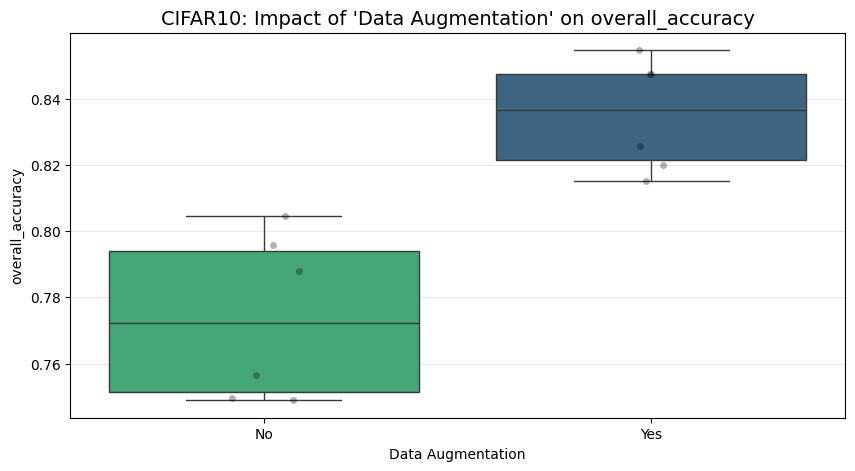

Saved: analyse_plot/impact_augmentation_cifar10_unfrozen.png


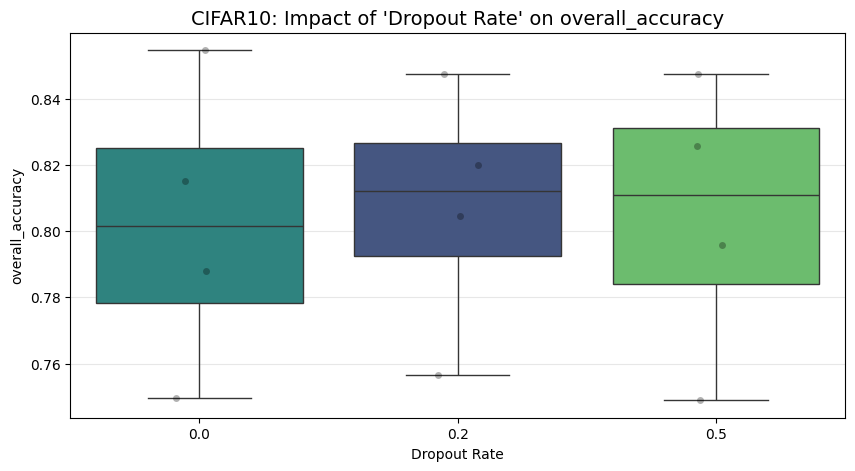

Saved: analyse_plot/impact_dropout_cifar10_unfrozen.png


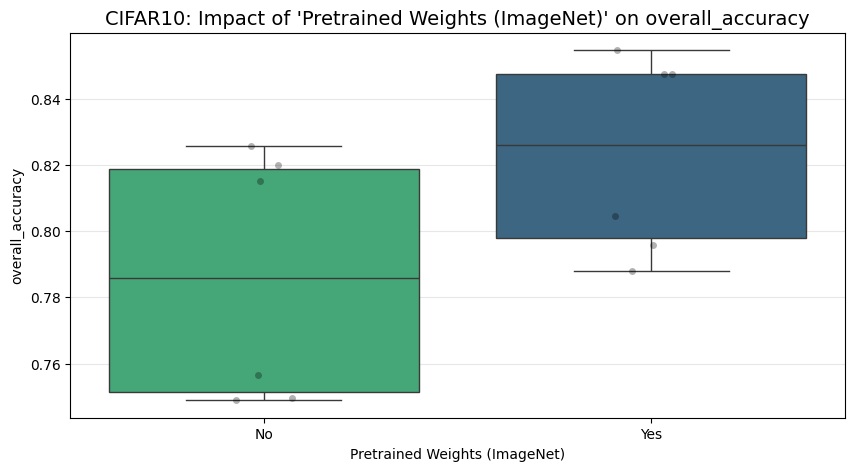

Saved: analyse_plot/impact_pretrained_cifar10_unfrozen.png

==================== 2. RUNTIME ANALYSIS (Freeze=Aus) ====================



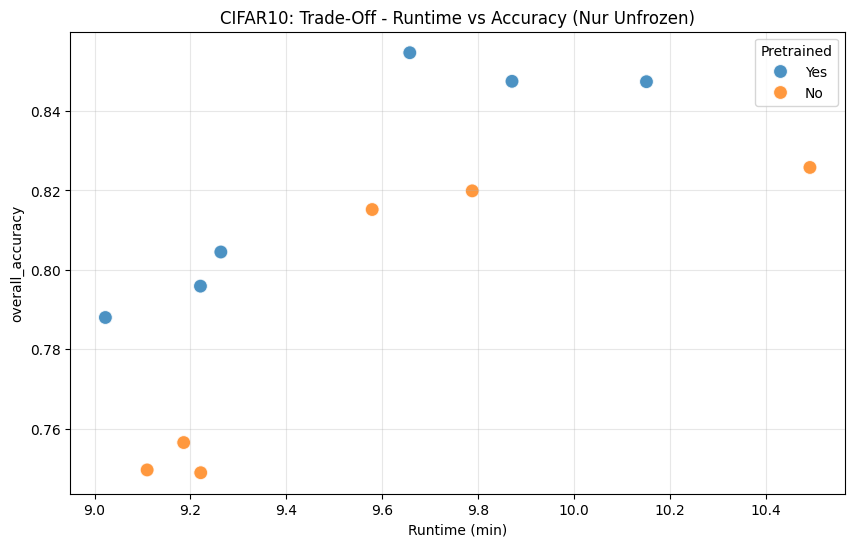

Saved: analyse_plot/tradeoff_runtime_accuracy_cifar10_unfrozen.png


In [21]:
# Funktion bleibt unverändert
def analyze_parameter_impact(df, param_col, title, y_metric="overall_accuracy", filename_suffix=""):
    if df.empty: 
        return
    
    # Falls die Spalte im gefilterten DF nur noch einen Wert hat, macht der Plot weniger Sinn,
    # wird aber trotzdem generiert (mit nur einer Box).
    
    plt.figure(figsize=(10, 5))
    order = sorted(df[param_col].unique())
    
    sns.boxplot(data=df, x=param_col, y=y_metric, order=order, palette="viridis", hue=param_col, legend=False)
    sns.stripplot(data=df, x=param_col, y=y_metric, color="black", alpha=0.3, jitter=True)
    
    plot_title = f"{SELECTED_DATASET.upper()}: Impact of '{title}' on {y_metric}"
    plt.title(plot_title, fontsize=14)
    plt.ylabel(y_metric)
    plt.xlabel(title)
    plt.grid(axis='y', alpha=0.3)
    
    # Sicherstellen, dass OUTPUT_DIR ein Path-Objekt ist
    out_path = Path(OUTPUT_DIR)
    out_path.mkdir(exist_ok=True, parents=True)
    
    filename = out_path / f"impact_{filename_suffix}_{SELECTED_DATASET}_unfrozen.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")

# ==========================================
# FILTER: NUR 'UNFROZEN' (Full Training)
# ==========================================
if not df.empty:
    # Wir erstellen eine Kopie, um das Original nicht zu verändern
    df_unfrozen = df.copy()
    
    # Prüfen, ob die Spalte "Freeze" existiert und filtern
    # Wir lassen nur Fälle zu, wo Freeze = 0, False, "Nein" oder "N" ist
    if "Freeze" in df_unfrozen.columns:
        df_unfrozen = df_unfrozen[df_unfrozen["Freeze"].isin([0, False, "No", "N"])]
        print(f"Datensatz gefiltert: Zeige nur Runs ohne Freeze (n={len(df_unfrozen)})")
    else:
        print("⚠️ Spalte 'Freeze' nicht gefunden, nutze alle Daten.")

    # ==========================================
    # 1. ACCURACY ANALYSIS (Gefiltert)
    # ==========================================
    if not df_unfrozen.empty:
        print(f"\n{'='*20} 1. ACCURACY ANALYSIS (Freeze=Aus) {'='*20}\n")
        
        analyze_parameter_impact(df_unfrozen, "Augmentation", "Data Augmentation", filename_suffix="augmentation")
        analyze_parameter_impact(df_unfrozen, "Dropout", "Dropout Rate", filename_suffix="dropout")
        analyze_parameter_impact(df_unfrozen, "Pretrained", "Pretrained Weights (ImageNet)", filename_suffix="pretrained")
        
        # Den "Freeze"-Plot lassen wir theoretisch drin, aber er wird nur 1 Balken zeigen (da wir ja gefiltert haben)
        # analyze_parameter_impact(df_unfrozen, "Freeze", "Freeze Backbone", filename_suffix="freeze")
        
        print(f"\n{'='*20} 2. RUNTIME ANALYSIS (Freeze=Aus) {'='*20}\n")
        
        # Runtime Analyse macht hier weniger Sinn für "Freeze", da es konstant ist, aber wir lassen die Struktur gleich
        if len(df_unfrozen["model"].unique()) > 1:
            analyze_parameter_impact(df_unfrozen, "model", "Model Architecture", y_metric="Runtime (min)", filename_suffix="model_runtime")
        
        # Scatterplot Update
        plt.figure(figsize=(10, 6))
        # style="Freeze" fällt weg bzw. ist konstant, daher entfernen wir es oder lassen es als konstantes Symbol
        sns.scatterplot(data=df_unfrozen, x="Runtime (min)", y="overall_accuracy", 
                        hue="Pretrained", s=100, alpha=0.8) # style="Freeze" entfernt, da konstant
        
        plt.title(f"{SELECTED_DATASET.upper()}: Trade-Off - Runtime vs Accuracy (Nur Unfrozen)")
        plt.grid(True, alpha=0.3)
        
        filename = Path(OUTPUT_DIR) / f"tradeoff_runtime_accuracy_{SELECTED_DATASET}_unfrozen.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Saved: {filename}")
    else:
        print("⚠️ Keine Daten vorhanden, bei denen Freeze='Nein' ist.")

Datensatz gefiltert: Zeige nur Runs ohne Freeze (n=12)

==================== 1. ACCURACY ANALYSIS (Freeze=Aus) ====================



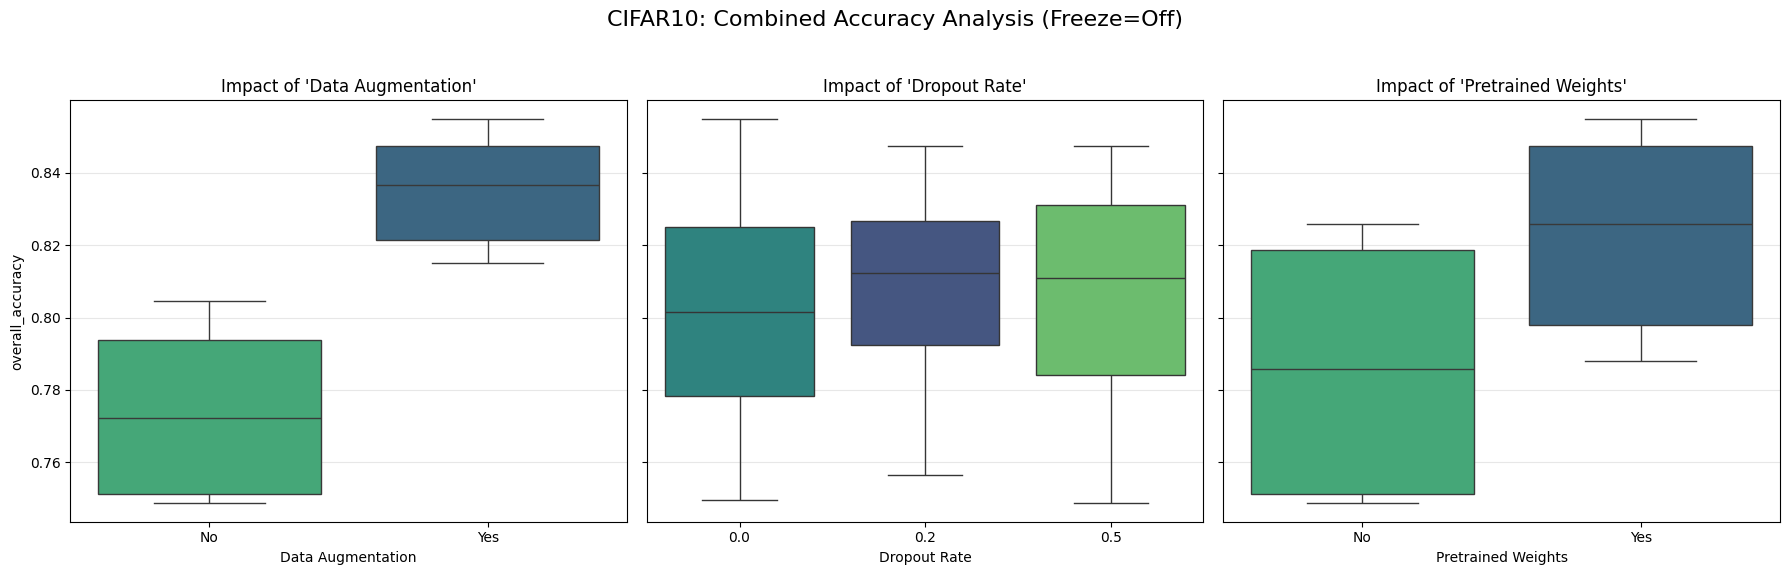

Saved: analyse_plot/combined_impacts_acc_cifar10_unfrozen.png

==================== 2. RUNTIME ANALYSIS (Freeze=Aus) ====================



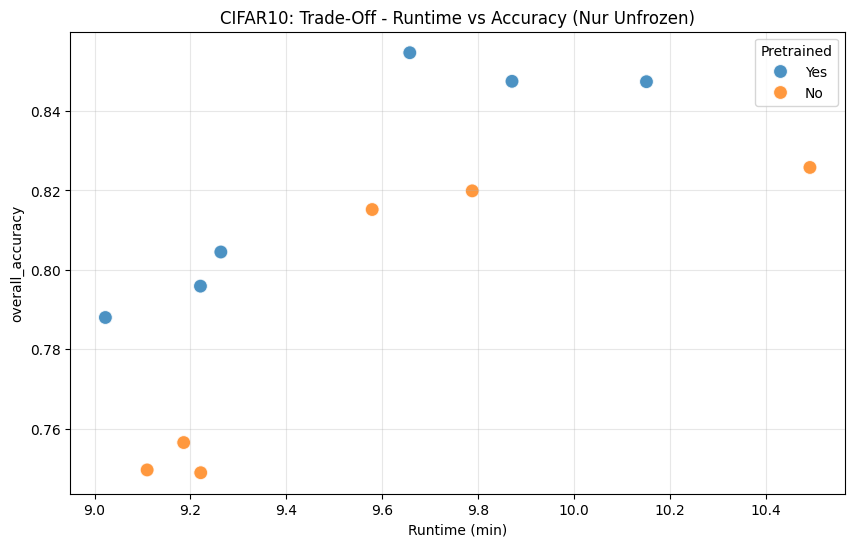

Saved: analyse_plot/tradeoff_runtime_accuracy_cifar10_unfrozen.png


In [22]:
# Vorhandene Funktion für Einzelplots (optional weiterhin nutzbar, z.B. für Runtime)
def analyze_parameter_impact(df, param_col, title, y_metric="overall_accuracy", filename_suffix=""):
    if df.empty: 
        return
    plt.figure(figsize=(10, 5))
    order = sorted(df[param_col].unique())
    
    sns.boxplot(data=df, x=param_col, y=y_metric, order=order, palette="viridis", hue=param_col, legend=False)
    # KLEINE PUNKTE ENTFERNT:
    # sns.stripplot(data=df, x=param_col, y=y_metric, color="black", alpha=0.3, jitter=True)
    
    plt.title(f"{SELECTED_DATASET.upper()}: Impact of '{title}' on {y_metric}", fontsize=14)
    plt.ylabel(y_metric)
    plt.xlabel(title)
    plt.grid(axis='y', alpha=0.3)
    out_path = Path(OUTPUT_DIR)
    out_path.mkdir(exist_ok=True, parents=True)
    filename = out_path / f"impact_{filename_suffix}_{SELECTED_DATASET}_unfrozen.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")

# NEUE FUNKTION: Erstellt 3 Boxplots nebeneinander (ohne Punkte)
def analyze_combined_impacts(df, params_list, y_metric="overall_accuracy"):
    if df.empty:
        return
    
    # Erstelle Figure mit 1 Zeile und 3 Spalten
    # sharey=True sorgt dafür, dass alle Plots die gleiche y-Achse nutzen
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    for i, (param_col, title, _) in enumerate(params_list):
        ax = axes[i]
        order = sorted(df[param_col].unique())
        
        sns.boxplot(data=df, x=param_col, y=y_metric, order=order, palette="viridis", 
                    hue=param_col, legend=False, ax=ax)
        
        # KLEINE PUNKTE ENTFERNT:
        # sns.stripplot(data=df, x=param_col, y=y_metric, color="black", 
        #               alpha=0.3, jitter=True, ax=ax)
        
        ax.set_title(f"Impact of '{title}'", fontsize=12)
        ax.set_ylabel(y_metric if i == 0 else "") # Y-Label nur beim ersten Plot
        ax.set_xlabel(title)
        ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle(f"{SELECTED_DATASET.upper()}: Combined Accuracy Analysis (Freeze=Off)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Platz für den Super-Titel lassen
    
    # Speichern des kombinierten Plots
    out_path = Path(OUTPUT_DIR)
    out_path.mkdir(exist_ok=True, parents=True)
    filename = out_path / f"combined_impacts_acc_{SELECTED_DATASET}_unfrozen.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")

# ==========================================
# FILTER: NUR 'UNFROZEN' (Full Training)
# ==========================================
if not df.empty:
    df_unfrozen = df.copy()
    
    if "Freeze" in df_unfrozen.columns:
        df_unfrozen = df_unfrozen[df_unfrozen["Freeze"].isin([0, False, "No", "N"])]
        print(f"Datensatz gefiltert: Zeige nur Runs ohne Freeze (n={len(df_unfrozen)})")
    else:
        print("⚠️ Spalte 'Freeze' nicht gefunden, nutze alle Daten.")

    if not df_unfrozen.empty:
        print(f"\n{'='*20} 1. ACCURACY ANALYSIS (Freeze=Aus) {'='*20}\n")
        
        # Liste der Parameter für den kombinierten Plot
        params_to_plot = [
            ("Augmentation", "Data Augmentation", "augmentation"),
            ("Dropout", "Dropout Rate", "dropout"),
            ("Pretrained", "Pretrained Weights", "pretrained")
        ]
        
        # Aufruf der neuen kombinierten Funktion (jetzt ohne Punkte)
        analyze_combined_impacts(df_unfrozen, params_to_plot)
        
        print(f"\n{'='*20} 2. RUNTIME ANALYSIS (Freeze=Aus) {'='*20}\n")
        
        # Runtime Analyse (Model-Architektur bleibt separat)
        if len(df_unfrozen["model"].unique()) > 1:
            analyze_parameter_impact(df_unfrozen, "model", "Model Architecture", 
                                     y_metric="Runtime (min)", filename_suffix="model_runtime")
        
        # Scatterplot Update
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df_unfrozen, x="Runtime (min)", y="overall_accuracy", 
                        hue="Pretrained", s=100, alpha=0.8)
        
        plt.title(f"{SELECTED_DATASET.upper()}: Trade-Off - Runtime vs Accuracy (Nur Unfrozen)")
        plt.grid(True, alpha=0.3)
        
        filename = Path(OUTPUT_DIR) / f"tradeoff_runtime_accuracy_{SELECTED_DATASET}_unfrozen.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Saved: {filename}")
    else:
        print("⚠️ Keine Daten vorhanden, bei denen Freeze='Nein' ist.")

Showing the 6 best curves (per Aug/Drop combination)...


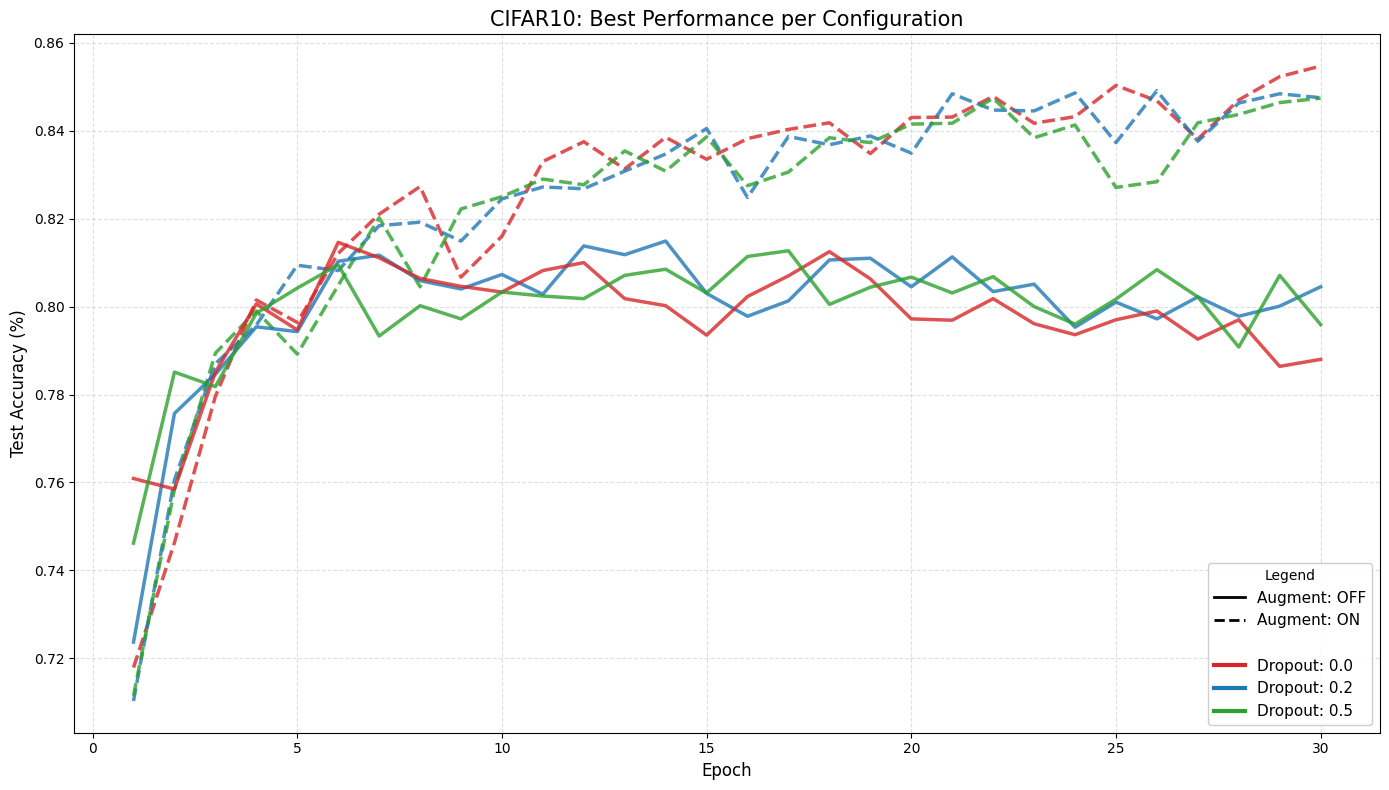

Saved: analyse_plot/benchmark_curves_cifar10.png


In [23]:
# ==========================================
# BENCHMARK PLOT (VISUALIZATION)
# ==========================================

LINESTYLES = {
    0: "-",
    1: "--"
}

COLORS = {
    0.0: "#d62728",
    0.2: "#1f77b4",
    0.5: "#2ca02c",
    0.8: "#9467bd"
}

def plot_benchmark_curves(df):
    if df.empty: 
        return
    
    plt.figure(figsize=(14, 8))
    
    def get_max_acc(hist):
        keys = ['eval_acc', 'val_acc', 'val_accuracy', 'balanced_accuracy', 'overall_accuracy']
        k = next((x for x in keys if x in hist), None)
        return max(hist[k]) if k and hist[k] else 0
    
    df["temp_max_acc"] = df["history"].apply(get_max_acc)
    df_sorted = df.sort_values(by="temp_max_acc", ascending=False)
    best_runs = df_sorted.drop_duplicates(subset=["augment", "dropout"])
    
    print(f"Showing the {len(best_runs)} best curves (per Aug/Drop combination)...")
    
    for _, row in best_runs.iterrows():
        hist = row["history"]
        val_acc_key = next((k for k in ['eval_acc', 'val_acc', 'balanced_accuracy', 'overall_accuracy'] if k in hist), None)
        
        if val_acc_key and len(hist[val_acc_key]) > 0:
            data = hist[val_acc_key]
            
            if MAX_VIEW_EPOCH:
                data = data[:MAX_VIEW_EPOCH]
            
            epochs = range(1, len(data) + 1)
            
            aug = int(row.get("augment", 0))
            drop = float(row.get("dropout", 0.0))
            
            ls = LINESTYLES.get(aug, "-")
            c = COLORS.get(drop, "gray")
            
            lbl = f"Aug={aug}, Drop={drop}, Pretr={row.get('Pretrained','?')}"
            plt.plot(epochs, data, color=c, linestyle=ls, linewidth=2.5, alpha=0.8, label=lbl)
    
    plt.title(f"{SELECTED_DATASET.upper()}: Best Performance per Configuration", fontsize=15)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Test Accuracy (%)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.4)
    
    legend_elements = []
    legend_elements.append(Line2D([0], [0], color='black', lw=2, linestyle='-', label='Augment: OFF'))
    legend_elements.append(Line2D([0], [0], color='black', lw=2, linestyle='--', label='Augment: ON'))
    legend_elements.append(Line2D([0], [0], color='white', label=' '))
    
    found_dropouts = sorted(best_runs["dropout"].unique())
    for d in found_dropouts:
        c = COLORS.get(d, "gray")
        legend_elements.append(Line2D([0], [0], color=c, lw=3, label=f'Dropout: {d}'))
    
    plt.legend(handles=legend_elements, loc='lower right', framealpha=0.95, fontsize=11, title="Legend")
    plt.tight_layout()
    
    filename = OUTPUT_DIR / f"benchmark_curves_{SELECTED_DATASET}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")

plot_benchmark_curves(df)

Creating plot for LR=0.001 ...


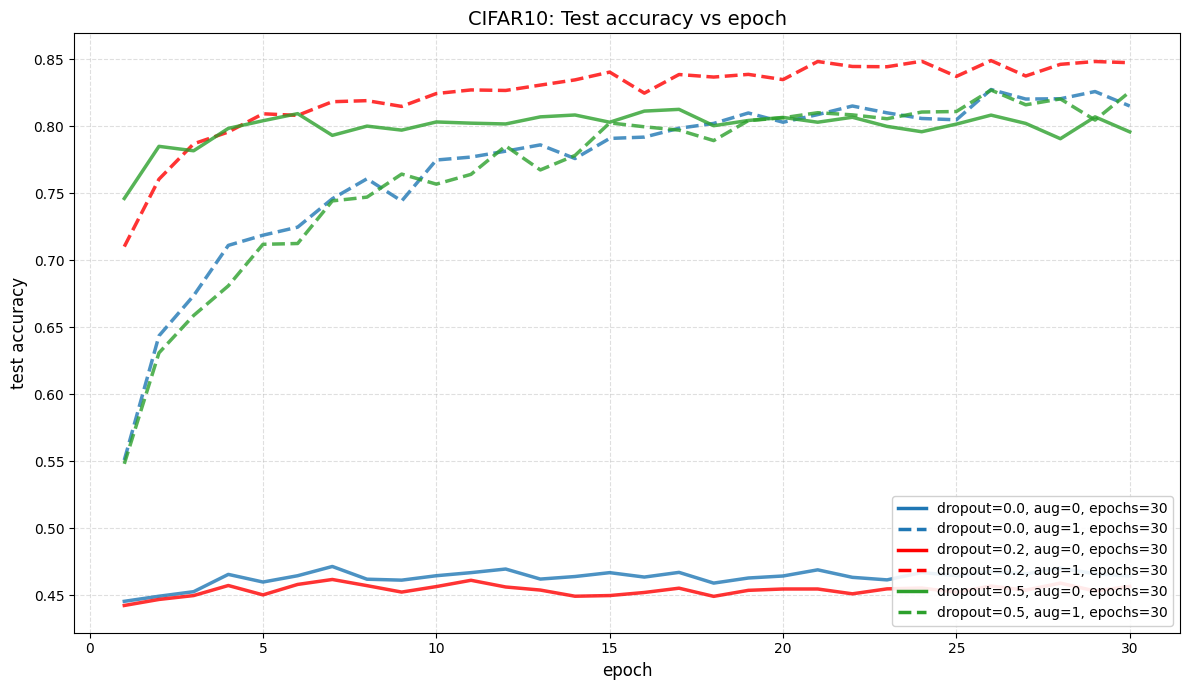

Saved: analyse_plot/dropout_analysis_lr0.001_cifar10.png


In [24]:
# ==========================================
# DROPOUT COLOR ANALYSIS
# ==========================================

TARGET_LR = 0.001

LINESTYLES = {
    0: "-",
    1: "--"
}

COLORS = {
    0.0: "#1f77b4",
    0.2: "#ff0000",
    0.5: "#2ca02c",
}

def plot_dropout_color_analysis(df, fixed_lr):
    if df.empty: 
        return
    
    subset = df[df["lr"].apply(lambda x: np.isclose(x, fixed_lr))].copy()
    
    if subset.empty:
        print(f"⚠️ No runs found with LR={fixed_lr}.")
        return
    
    print(f"Creating plot for LR={fixed_lr} ...")
    
    if 'epochs' not in subset.columns:
        subset['epochs'] = subset['history'].apply(lambda h: len(h.get('eval_acc', h.get('val_acc', h.get('overall_accuracy', [])))))
    
    subset = subset.loc[subset.groupby(['dropout', 'augment'])['epochs'].idxmax()]
    
    plt.figure(figsize=(12, 7))
    subset = subset.sort_values(by=["dropout", "augment"])
    
    legend_elements = []
    
    for _, row in subset.iterrows():
        hist = row["history"]
        val_acc_key = next((k for k in ['eval_acc', 'val_acc', 'overall_accuracy'] if k in hist), None)
        
        if val_acc_key and len(hist[val_acc_key]) > 0:
            y_data = hist[val_acc_key]
            x_data = range(1, len(y_data) + 1)
            
            aug = int(row.get("augment", 0))
            drop = float(row.get("dropout", 0.0))
            epochs = int(row.get("epochs", len(y_data)))
            
            ls = LINESTYLES.get(aug, "-")
            c = COLORS.get(drop, "gray")
            
            plt.plot(x_data, y_data, color=c, linestyle=ls, linewidth=2.5, alpha=0.8)
            
            label = f"dropout={drop}, aug={aug}, epochs={epochs}"
            legend_elements.append(
                Line2D([0], [0], 
                       color=c, 
                       linestyle=ls,
                       lw=2.5, 
                       label=label)
            )
    
    plt.title(f"{SELECTED_DATASET.upper()}: Test accuracy vs epoch", fontsize=14)
    plt.xlabel("epoch", fontsize=12)
    plt.ylabel("test accuracy", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend(handles=legend_elements, loc='lower right', framealpha=0.9, fontsize=10)
    plt.tight_layout()
    
    filename = OUTPUT_DIR / f"dropout_analysis_lr{fixed_lr}_{SELECTED_DATASET}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")

plot_dropout_color_analysis(df, TARGET_LR)

Creating plot for LR=0.001 with Freeze as primary factor...


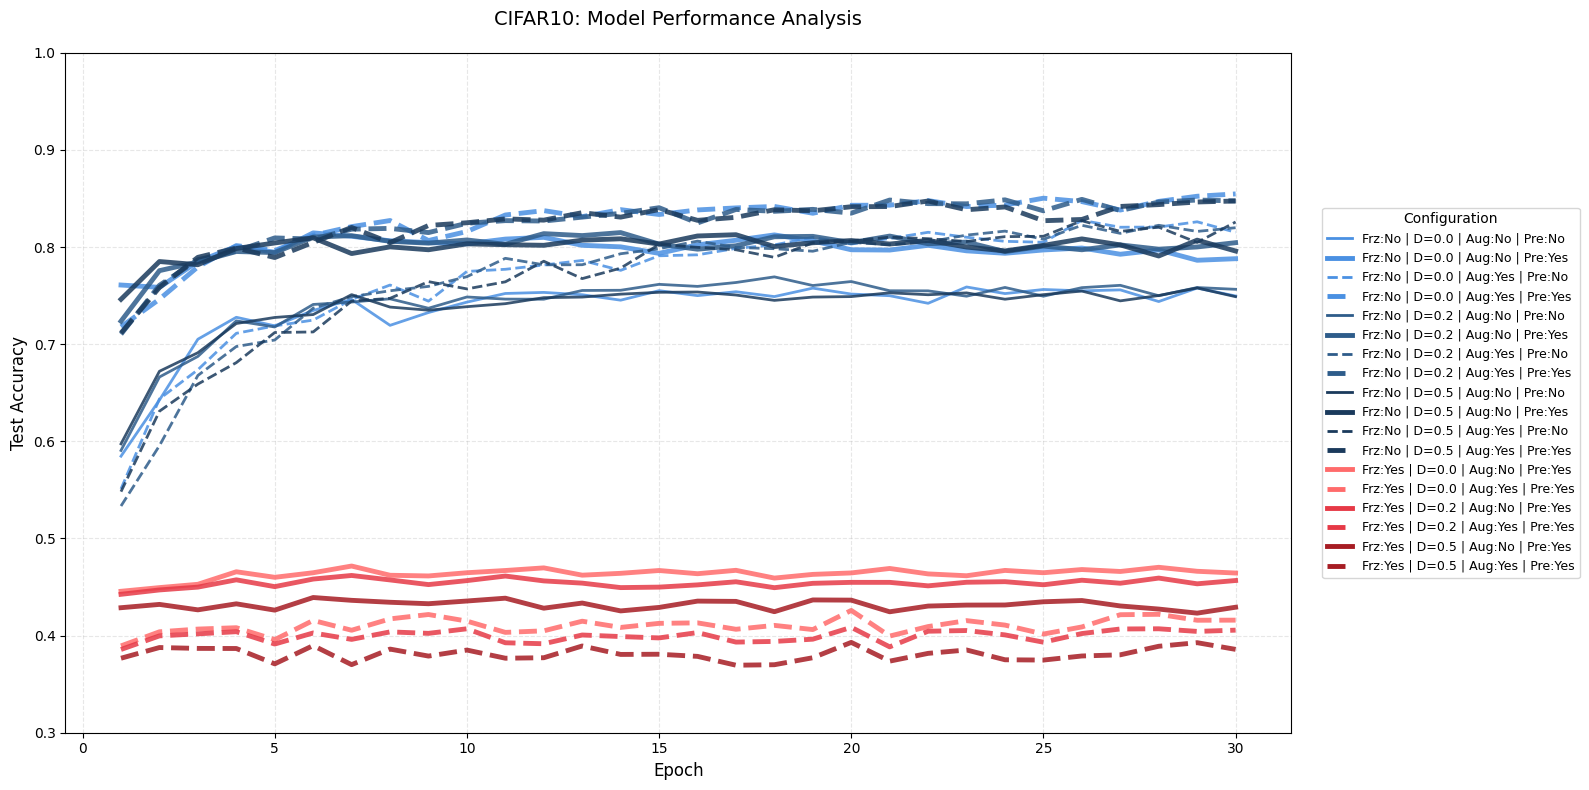

Saved: analyse_plot/extended_config_analysis_lr0.001_cifar10.png


In [25]:
# ==========================================
# EXTENDED CONFIG ANALYSIS WITH FREEZE
# ==========================================

TARGET_LR = 0.001

FREEZE_COLORS = {
    0: {
        0.0: "#4A90E2",
        0.2: "#2E5C8A",
        0.5: "#1A3A5C",
    },
    1: {
        0.0: "#FF6B6B",
        0.2: "#E63946",
        0.5: "#A61C23",
    }
}

LINESTYLES = {
    0: "-",
    1: "--"
}

LINEWIDTHS = {
    0: 2.0,
    1: 3.5
}

def plot_extended_config_analysis(df, fixed_lr):
    if df.empty:
        return
    
    subset = df[df["lr"].apply(lambda x: np.isclose(x, fixed_lr))].copy()
    
    if subset.empty:
        print(f"⚠️ No runs found with LR={fixed_lr}")
        return
    
    print(f"Creating plot for LR={fixed_lr} with Freeze as primary factor...")
    
    for col in ['freeze_backbone', 'pretrained', 'dropout', 'augment']:
        if col not in subset.columns:
            subset[col] = 0
    
    if 'epochs' not in subset.columns:
        subset['epochs'] = subset['history'].apply(
            lambda h: len(h.get('eval_acc', h.get('val_acc', h.get('overall_accuracy', []))))
        )
    
    group_cols = ['freeze_backbone', 'dropout', 'augment', 'pretrained']
    idx_to_keep = subset.groupby(group_cols)['epochs'].idxmax()
    subset = subset.loc[idx_to_keep]
    
    subset = subset.sort_values(by=['freeze_backbone', 'dropout', 'augment', 'pretrained'])
    
    plt.figure(figsize=(16, 8))
    legend_elements = []
    
    for _, row in subset.iterrows():
        hist = row["history"]
        val_acc_key = next((k for k in ['eval_acc', 'val_acc', 'overall_accuracy'] if k in hist), None)
        
        if val_acc_key and len(hist[val_acc_key]) > 0:
            y_data = hist[val_acc_key]
            x_data = range(1, len(y_data) + 1)
            
            frz = int(row.get("freeze_backbone", 0))
            drop = float(row.get("dropout", 0.0))
            aug = int(row.get("augment", 0))
            ptr = int(row.get("pretrained", 0))
            
            color = FREEZE_COLORS.get(frz, {}).get(drop, "gray")
            linestyle = LINESTYLES.get(aug, "-")
            linewidth = LINEWIDTHS.get(ptr, 2.0)
            
            plt.plot(x_data, y_data, 
                    color=color, 
                    linestyle=linestyle, 
                    linewidth=linewidth, 
                    alpha=0.85)
            
            frz_label = "Frz:Yes" if frz == 1 else "Frz:No"
            aug_label = "Aug:Yes" if aug == 1 else "Aug:No"
            ptr_label = "Pre:Yes" if ptr == 1 else "Pre:No"
            label = f"{frz_label} | D={drop} | {aug_label} | {ptr_label}"
            
            legend_elements.append(
                Line2D([0], [0], 
                       color=color, 
                       linestyle=linestyle,
                       linewidth=linewidth,
                       label=label)
            )
    
    plt.title(f"{SELECTED_DATASET.upper()}: Model Performance Analysis", 
              fontsize=14, pad=20)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Test Accuracy", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.ylim([0.3, 1.0])
    
    plt.legend(handles=legend_elements, 
               loc='center left', 
               bbox_to_anchor=(1.02, 0.5),
               title="Configuration", 
               fontsize=9)
    
    plt.tight_layout()
    
    filename = OUTPUT_DIR / f"extended_config_analysis_lr{fixed_lr}_{SELECTED_DATASET}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")

plot_extended_config_analysis(df, TARGET_LR)

Showing 12 curves (Filter: Freeze=Off)...


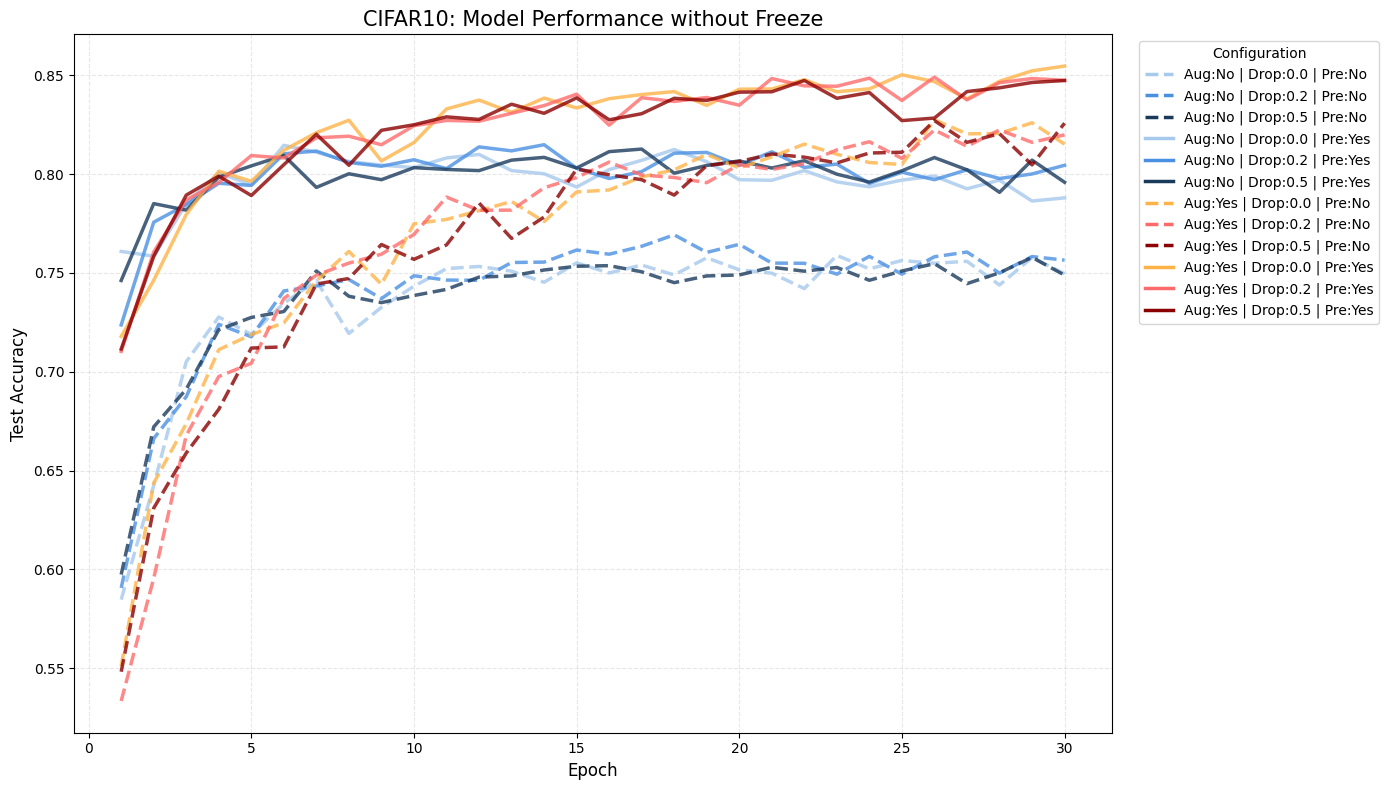

Saved: analyse_plot/interaction_analysis_lr0.001_cifar10.png


In [26]:
# ==========================================
# COMPLEX INTERACTIONS ANALYSIS
# ==========================================

TARGET_LR = 0.001

COLOR_MAP = {
    (0, 0.0): "#A6C9EC",
    (0, 0.2): "#4A90E2",
    (0, 0.5): "#1A3A5C",
    (1, 0.0): "#FFB347",
    (1, 0.2): "#FF6B6B",
    (1, 0.5): "#8B0000",
}

LINESTYLES = {
    1: "-",
    0: "--"
}

def plot_complex_interactions_autoscale(df, fixed_lr):
    if df.empty: 
        return
    
    subset = df[df["lr"].apply(lambda x: np.isclose(x, fixed_lr))].copy()
    
    for col in ['freeze_backbone', 'pretrained', 'dropout', 'augment']:
        if col not in subset.columns: 
            subset[col] = 0
    
    subset = subset[subset["freeze_backbone"].isin([0, False, "No", "N"])]
    
    if subset.empty:
        print(f"⚠️ No unfrozen runs for LR={fixed_lr}.")
        return
    
    print(f"Showing {len(subset)} curves (Filter: Freeze=Off)...")
    
    if 'epochs' not in subset.columns:
        subset['epochs'] = subset['history'].apply(lambda h: len(next(iter(h.values()))))
    
    group_cols = ['dropout', 'augment', 'pretrained']
    subset = subset.loc[subset.groupby(group_cols)['epochs'].idxmax()]
    
    subset = subset.sort_values(by=['augment', 'pretrained', 'dropout'])
    
    plt.figure(figsize=(14, 8))
    legend_elements = []
    all_y_values = []
    
    for _, row in subset.iterrows():
        hist = row["history"]
        val_acc_key = next((k for k in ['eval_acc', 'val_acc', 'overall_accuracy'] if k in hist), None)
        
        if val_acc_key and len(hist[val_acc_key]) > 0:
            y_data = hist[val_acc_key]
            x_data = range(1, len(y_data) + 1)
            
            all_y_values.extend(y_data)
            
            drop = float(row.get("dropout", 0.0))
            aug = int(row.get("augment", 0))
            ptr = int(row.get("pretrained", 0))
            
            color = COLOR_MAP.get((aug, drop), "gray")
            ls = LINESTYLES.get(ptr, "-")
            
            plt.plot(x_data, y_data, color=color, linestyle=ls, linewidth=2.5, alpha=0.8)
            
            aug_txt = "Aug:Yes" if aug else "Aug:No"
            pre_txt = "Pre:Yes" if ptr else "Pre:No"
            label = f"{aug_txt} | Drop:{drop} | {pre_txt}"
            
            legend_elements.append(
                Line2D([0], [0], color=color, linestyle=ls, linewidth=2.5, label=label)
            )
    
    plt.title(f"{SELECTED_DATASET.upper()}: Model Performance without Freeze", fontsize=15)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Test Accuracy", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.3)
    
    if all_y_values:
        y_min, y_max = min(all_y_values), max(all_y_values)
        margin = (y_max - y_min) * 0.05
        plt.ylim([max(0, y_min - margin), min(1.0, y_max + margin)])
    
    plt.legend(handles=legend_elements, title="Configuration", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    
    filename = OUTPUT_DIR / f"interaction_analysis_lr{fixed_lr}_{SELECTED_DATASET}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")

plot_complex_interactions_autoscale(df, TARGET_LR)

In [27]:
# ==========================================
# KONFIGURATION
# ==========================================
THRESHOLD_TOLERANCE = 0.02

def get_convergence_info(history):
    """Berechnet Max Acc, Efficient Epoch und Zeit-Metriken."""
    keys = ['eval_acc', 'val_acc', 'val_accuracy', 'balanced_accuracy', 'overall_accuracy', 'accuracy']
    val_acc_key = next((k for k in keys if k in history), None)
    train_times = history.get("train_time_s", [])
    
    if val_acc_key and history[val_acc_key]:
        values = history[val_acc_key]
        max_idx = np.argmax(values)
        max_val = values[max_idx]
        
        target_val = max_val * (1 - THRESHOLD_TOLERANCE)
        candidates = np.where(np.array(values[:max_idx+1]) >= target_val)[0]
        
        if len(candidates) > 0:
            eff_idx = candidates[0]
            eff_acc = values[eff_idx]
        else:
            eff_idx = max_idx 
            eff_acc = max_val
            
        time_to_peak = sum(train_times[:max_idx+1]) / 60.0 if train_times else 0.0
        time_to_eff  = sum(train_times[:eff_idx+1]) / 60.0 if train_times else 0.0

        return {
            "max_epoch": max_idx + 1,
            "max_acc": max_val,
            "time_to_peak": time_to_peak,
            "eff_epoch": eff_idx + 1,
            "eff_acc": eff_acc,
            "time_to_eff": time_to_eff
        }
    return {
        "max_epoch": None, "max_acc": 0, "time_to_peak": 0,
        "eff_epoch": None, "eff_acc": 0, "time_to_eff": 0
    }

def create_advanced_summary(df, dataset_name="gtsrb", output_dir="analyse_plot"):
    if df.empty: return
    
    subset = df.copy()
    
    # 1. Spalten-Bereinigung (Self-Healing)
    # Wir stellen sicher, dass wir standardisierte Namen haben (lowercase)
    # Falls Chunk 2 "Freeze" (groß) erstellt hat, mappen wir es auf "freeze_backbone" (klein)
    
    if "Pretrained" in subset.columns and "pretrained" not in subset.columns:
        subset["pretrained"] = subset["Pretrained"].apply(lambda x: 1 if x == "Ja" else 0)
    
    if "Freeze" in subset.columns and "freeze_backbone" not in subset.columns:
        subset["freeze_backbone"] = subset["Freeze"].apply(lambda x: 1 if x == "Ja" else 0)

    # Falls sie gar nicht existieren, mit 0 auffüllen
    for c in ["augment", "dropout", "pretrained", "freeze_backbone"]:
        if c not in subset.columns: 
            subset[c] = 0

    # Runtime berechnen
    if "Runtime (min)" not in subset.columns:
        subset["Runtime (min)"] = subset["history"].apply(
            lambda h: sum(h.get("train_time_s", []))/60.0
        )

    # 2. Metriken berechnen
    metrics_df = subset["history"].apply(lambda h: pd.Series(get_convergence_info(h)))
    subset = pd.concat([subset, metrics_df], axis=1)
    
    # 3. Sortieren & Filtern (Längster Run gewinnt)
    subset = subset.sort_values(by=["epochs", "max_acc"], ascending=[False, False])
    
    group_cols = ["augment", "dropout", "pretrained", "freeze_backbone"]
    best_runs = subset.drop_duplicates(subset=group_cols)
    
    # 4. Spalten auswählen (Explizit definiert)
    cols = [
        "augment", "dropout", "pretrained", "freeze_backbone", # Hyperparameter
        "epochs", "Runtime (min)",                             # Basics
        "max_acc", "max_epoch", "time_to_peak",                # Peak Performance
        "eff_epoch", "time_to_eff",                            # Efficiency
        "F1-Score"                                             # Falls vorhanden
    ]
    
    # Nur nehmen, was da ist
    cols = [c for c in cols if c in best_runs.columns]
    
    # Sortieren nach Erfolg
    sort_crit = "F1-Score" if "F1-Score" in best_runs.columns else "max_acc"
    final_table = best_runs[cols].sort_values(by=[sort_crit], ascending=False)
    
    # 5. Umbenennen
    eff_ep_name = f"Eff. Ep ({int((1-THRESHOLD_TOLERANCE)*100)}%)"
    rename_map = {
        "augment": "Aug", 
        "dropout": "Drop", 
        "pretrained": "Pretr.", 
        "freeze_backbone": "Frz.",
        "epochs": "Total Ep", 
        "Runtime (min)": "Total Time",
        "max_acc": "Max Acc", 
        "max_epoch": "Peak Ep", 
        "time_to_peak": "Time @ Peak",
        "eff_epoch": eff_ep_name, 
        "time_to_eff": "Time @ Eff",
        "F1-Score": "Weighted F1"
    }
    final_table = final_table.rename(columns=rename_map)
    
    # 6. Formatierung: 0/1 zu Ja/Nein machen
    for col in ["Aug", "Pretr.", "Frz."]:
        if col in final_table.columns:
            # Robuste Konvertierung: Alles was wie 'True' oder '1' aussieht wird 'Ja'
            final_table[col] = final_table[col].apply(
                lambda x: "Ja" if x in [1, 1.0, True, "Ja", "True"] else "Nein"
            )

    # Speichern
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    csv_filename = f"{dataset_name}_final_analysis_fixed.csv"
    final_table.to_csv(output_path / csv_filename, index=False)
    print(f"✓ Tabelle gespeichert: {output_path / csv_filename}")
    
    # Anzeige
    print(f"\n--- FINALE ANALYSE (Alle Spalten repariert) ---")
    
    styler = final_table.style.background_gradient(subset=["Max Acc"], cmap="Greens")
    
    if "Weighted F1" in final_table.columns:
        styler = styler.background_gradient(subset=["Weighted F1"], cmap="Greens")
        
    # Zeit Spalten
    time_cols = [c for c in ["Total Time", "Time @ Peak", "Time @ Eff"] if c in final_table.columns]
    if time_cols: styler = styler.background_gradient(subset=time_cols, cmap="Reds")
        
    # Efficiency Spalte
    if eff_ep_name in final_table.columns:
        styler = styler.background_gradient(subset=[eff_ep_name], cmap="YlOrRd_r")

    display(styler.format({
        "Max Acc": "{:.2%}", "Weighted F1": "{:.2%}",
        "Total Ep": "{:.0f}", "Peak Ep": "{:.0f}", eff_ep_name: "{:.0f}",
        "Total Time": "{:.1f} min", "Time @ Peak": "{:.1f} min", "Time @ Eff": "{:.1f} min",
        "Drop": "{:.1f}"
    }, na_rep="-"))
    
    return final_table

# Ausführen
result_table = create_advanced_summary(df, dataset_name=SELECTED_DATASET)

✓ Tabelle gespeichert: analyse_plot/cifar10_final_analysis_fixed.csv

--- FINALE ANALYSE (Alle Spalten repariert) ---


,Aug,Drop,Pretr.,Frz.,Total Ep,Total Time,Max Acc,Peak Ep,Time @ Peak,Eff. Ep (98%),Time @ Eff
17,Ja,0.0,Ja,Nein,30,9.7 min,85.47%,30,9.7 min,14,4.5 min
0,Ja,0.2,Ja,Nein,30,9.9 min,84.91%,26,8.6 min,14,4.7 min
16,Ja,0.5,Ja,Nein,30,10.2 min,84.74%,22,7.5 min,13,4.4 min
6,Ja,0.0,Nein,Nein,30,9.6 min,82.75%,26,8.3 min,22,7.0 min
5,Ja,0.5,Nein,Nein,30,10.5 min,82.71%,26,9.1 min,24,8.4 min
14,Ja,0.2,Nein,Nein,30,9.8 min,82.24%,26,8.5 min,16,5.2 min
10,Nein,0.2,Ja,Nein,30,9.3 min,81.49%,14,4.4 min,6,1.9 min
2,Nein,0.0,Ja,Nein,30,9.0 min,81.46%,6,1.8 min,4,1.2 min
4,Nein,0.5,Ja,Nein,30,9.2 min,81.27%,17,5.2 min,4,1.3 min
12,Nein,0.2,Nein,Nein,30,9.2 min,76.93%,18,5.5 min,13,3.9 min


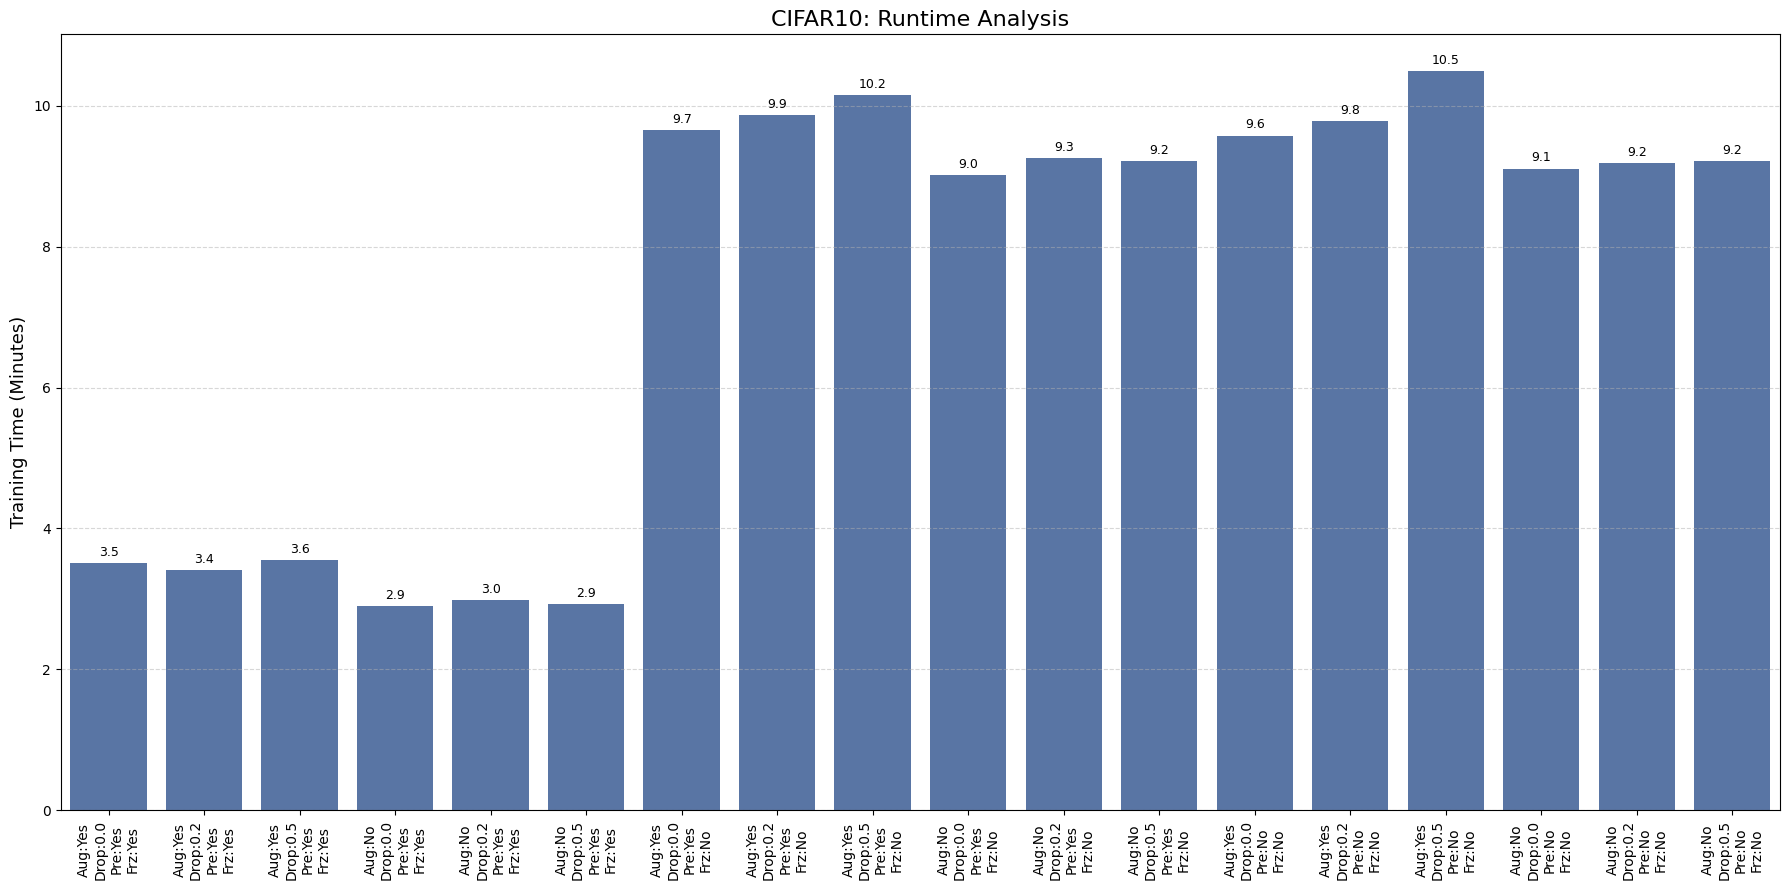

Saved: analyse_plot/runtime_analysis_grouped_cifar10.png


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_final_runtime_analysis(df_table):
    if df_table is None or df_table.empty:
        print("⚠️ No data available (result_table is empty).")
        return
    
    plot_df = df_table.copy()
    
    time_col = "Total Time" if "Total Time" in plot_df.columns else "Runtime (min)"
    if time_col not in plot_df.columns:
        print("⚠️ No time column found.")
        return
    
    sort_cols = ["Pretr.", "Frz.", "Aug", "Drop"]
    existing_sort_cols = [c for c in sort_cols if c in plot_df.columns]
    
    if existing_sort_cols:
        plot_df = plot_df.sort_values(by=existing_sort_cols, ascending=True)
    
    def create_label(row):
        a = "Yes" if row["Aug"] in ["Yes", "Ja", 1, True] else "No"
        p = "Yes" if row["Pretr."] in ["Yes", "Ja", 1, True] else "No"
        f = "Yes" if row["Frz."] in ["Yes", "Ja", 1, True] else "No"
        d = row["Drop"]
        return f"Aug:{a}\nDrop:{d}\nPre:{p}\nFrz:{f}"
    
    plot_df["Config_Label"] = plot_df.apply(create_label, axis=1)
    
    plt.figure(figsize=(18, 9))
    
    bar_plot = sns.barplot(
        data=plot_df, 
        x="Config_Label", 
        y=time_col, 
        color="#4c72b0" 
    )
    
    plt.title(f"{SELECTED_DATASET.upper()}: Runtime Analysis", fontsize=16)
    plt.ylabel("Training Time (Minutes)", fontsize=13)
    plt.xlabel("")
    
    plt.xticks(rotation=0, fontsize=9)
    plt.xticks(rotation=90, fontsize=10)
    
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    for p in bar_plot.patches:
        height = p.get_height()
        if height > 0:
            bar_plot.annotate(f'{height:.1f}', 
                              (p.get_x() + p.get_width() / 2., height), 
                              ha='center', va='bottom', 
                              xytext=(0, 3), 
                              textcoords='offset points',
                              fontsize=9)
    
    plt.tight_layout()
    
    filename = OUTPUT_DIR / f"runtime_analysis_grouped_{SELECTED_DATASET}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")

plot_final_runtime_analysis(result_table)

In [29]:
# ==========================================
# ADVANCED SUMMARY TABLE
# ==========================================

THRESHOLD_TOLERANCE = 0.01

def get_convergence_info(history):
    keys = ['eval_acc', 'val_acc', 'val_accuracy', 'balanced_accuracy', 'overall_accuracy', 'accuracy']
    val_acc_key = next((k for k in keys if k in history), None)
    train_times = history.get("train_time_s", [])
    
    if val_acc_key and history[val_acc_key]:
        values = history[val_acc_key]
        max_idx = np.argmax(values)
        max_val = values[max_idx]
        
        target_val = max_val * (1 - THRESHOLD_TOLERANCE)
        candidates = np.where(np.array(values[:max_idx+1]) >= target_val)[0]
        
        if len(candidates) > 0:
            eff_idx = candidates[0]
            eff_acc = values[eff_idx]
        else:
            eff_idx = max_idx 
            eff_acc = max_val
        
        time_to_peak = sum(train_times[:max_idx+1]) / 60.0 if train_times else 0.0
        time_to_eff  = sum(train_times[:eff_idx+1]) / 60.0 if train_times else 0.0
        
        return {
            "max_epoch": max_idx + 1,
            "max_acc": max_val,
            "time_to_peak": time_to_peak,
            "eff_epoch": eff_idx + 1,
            "eff_acc": eff_acc,
            "time_to_eff": time_to_eff
        }
    
    return {
        "max_epoch": None, "max_acc": 0, "time_to_peak": 0,
        "eff_epoch": None, "eff_acc": 0, "time_to_eff": 0
    }

def create_advanced_summary(df, dataset_name="gtsrb"):
    if df.empty: 
        return
    
    subset = df.copy()
    
    if "Pretrained" in subset.columns and "pretrained" not in subset.columns:
        subset["pretrained"] = subset["Pretrained"].apply(lambda x: 1 if x == "Yes" else 0)
    
    if "Freeze" in subset.columns and "freeze_backbone" not in subset.columns:
        subset["freeze_backbone"] = subset["Freeze"].apply(lambda x: 1 if x == "Yes" else 0)
    
    for c in ["augment", "dropout", "pretrained", "freeze_backbone"]:
        if c not in subset.columns: 
            subset[c] = 0
    
    if "Runtime (min)" not in subset.columns:
        subset["Runtime (min)"] = subset["history"].apply(
            lambda h: sum(h.get("train_time_s", []))/60.0
        )
    
    metrics_df = subset["history"].apply(lambda h: pd.Series(get_convergence_info(h)))
    subset = pd.concat([subset, metrics_df], axis=1)
    
    subset = subset.sort_values(by=["epochs", "max_acc"], ascending=[False, False])
    group_cols = ["augment", "dropout", "pretrained", "freeze_backbone"]
    best_runs = subset.drop_duplicates(subset=group_cols)
    
    cols = [
        "augment", "dropout", "pretrained", "freeze_backbone",
        "epochs", "Runtime (min)",
        "max_acc", "max_epoch", "time_to_peak",
        "eff_epoch", "time_to_eff",
        "F1-Score"
    ]
    
    cols = [c for c in cols if c in best_runs.columns]
    
    sort_crit = "F1-Score" if "F1-Score" in best_runs.columns else "max_acc"
    final_table = best_runs[cols].sort_values(by=[sort_crit], ascending=False)
    
    eff_ep_name = f"Eff. Ep ({int((1-THRESHOLD_TOLERANCE)*100)}%)"
    rename_map = {
        "augment": "Aug", 
        "dropout": "Drop", 
        "pretrained": "Pretr.", 
        "freeze_backbone": "Frz.",
        "epochs": "Total Ep", 
        "Runtime (min)": "Total Time",
        "max_acc": "Max Acc", 
        "max_epoch": "Peak Ep", 
        "time_to_peak": "Time @ Peak",
        "eff_epoch": eff_ep_name, 
        "time_to_eff": "Time @ Eff",
        "F1-Score": "Weighted F1"
    }
    final_table = final_table.rename(columns=rename_map)
    
    for col in ["Aug", "Pretr.", "Frz."]:
        if col in final_table.columns:
            final_table[col] = final_table[col].apply(
                lambda x: "Yes" if x in [1, 1.0, True, "Yes", "True"] else "No"
            )
    
    csv_filename = f"final_analysis_{dataset_name}.csv"
    final_table.to_csv(OUTPUT_DIR / csv_filename, index=False)
    print(f"✓ Table saved: {OUTPUT_DIR / csv_filename}")
    
    print(f"\n--- {dataset_name.upper()}: FINAL ANALYSIS ---")
    styler = final_table.style.background_gradient(subset=["Max Acc"], cmap="Greens")
    
    if "Weighted F1" in final_table.columns:
        styler = styler.background_gradient(subset=["Weighted F1"], cmap="Greens")
    
    time_cols = [c for c in ["Total Time", "Time @ Peak", "Time @ Eff"] if c in final_table.columns]
    if time_cols: 
        styler = styler.background_gradient(subset=time_cols, cmap="Reds")
    
    if eff_ep_name in final_table.columns:
        styler = styler.background_gradient(subset=[eff_ep_name], cmap="YlOrRd_r")
    
    display(styler.format({
        "Max Acc": "{:.2%}", "Weighted F1": "{:.2%}",
        "Total Ep": "{:.0f}", "Peak Ep": "{:.0f}", eff_ep_name: "{:.0f}",
        "Total Time": "{:.1f} min", "Time @ Peak": "{:.1f} min", "Time @ Eff": "{:.1f} min",
        "Drop": "{:.1f}"
    }, na_rep="-"))
    
    return final_table

result_table = create_advanced_summary(df, dataset_name=SELECTED_DATASET)

✓ Table saved: analyse_plot/final_analysis_cifar10.csv

--- CIFAR10: FINAL ANALYSIS ---


,Aug,Drop,Pretr.,Frz.,Total Ep,Total Time,Max Acc,Peak Ep,Time @ Peak,Eff. Ep (99%),Time @ Eff
17,Yes,0.0,Yes,No,30,9.7 min,85.47%,30,9.7 min,22,7.1 min
0,Yes,0.2,Yes,No,30,9.9 min,84.91%,26,8.6 min,21,7.0 min
16,Yes,0.5,Yes,No,30,10.2 min,84.74%,22,7.5 min,20,6.7 min
6,Yes,0.0,No,No,30,9.6 min,82.75%,26,8.3 min,26,8.3 min
5,Yes,0.5,No,No,30,10.5 min,82.71%,26,9.1 min,26,9.1 min
14,Yes,0.2,No,No,30,9.8 min,82.24%,26,8.5 min,24,7.8 min
10,No,0.2,Yes,No,30,9.3 min,81.49%,14,4.4 min,6,1.9 min
2,No,0.0,Yes,No,30,9.0 min,81.46%,6,1.8 min,6,1.8 min
4,No,0.5,Yes,No,30,9.2 min,81.27%,17,5.2 min,6,1.9 min
12,No,0.2,No,No,30,9.2 min,76.93%,18,5.5 min,17,5.2 min


In [30]:
def generate_latex_from_best_run(df, dataset_name="cifar10"):
    if df.empty: 
        return
    
    work_df = df.copy()
    
    if "epochs" not in work_df.columns:
        work_df["epochs"] = work_df["history"].apply(
            lambda h: len(h.get('eval_acc', h.get('val_acc', h.get('overall_accuracy', []))))
        )
    
    sort_col = "F1-Score" if "F1-Score" in work_df.columns else "overall_accuracy"
    best_run = work_df.sort_values(by=["epochs", sort_col], ascending=[False, False]).iloc[0]
    
    print(f"--- LATEX GENERATOR ---")
    print(f"Best run found: {best_run['run_id']}")
    print(f"Stats: Epochs={best_run['epochs']}, {sort_col}={best_run.get(sort_col, 0):.4f}")
    
    found_dirs = list(RUNS_DIR.rglob(best_run["run_id"]))
    if not found_dirs:
        print("❌ Error: Run directory not found.")
        return
    
    report_path = found_dirs[0] / "report.txt"
    if not report_path.exists():
        print(f"❌ Error: No report.txt found in {found_dirs[0]}.")
        return
    
    lines = report_path.read_text().splitlines()
    
    latex_output = []
    latex_output.append("\\begin{table}[H]")
    latex_output.append("\\centering")
    latex_output.append("\\begin{tabular}{|c|c|c|c|c|}")
    latex_output.append("\\hline")
    latex_output.append(" \\textbf{class} & \\textbf{precision} & \\textbf{recall} & \\textbf{f1-score} & \\textbf{support} \\\\ \\hline")
    
    for line in lines:
        parts = line.split()
        if not parts: 
            continue
        
        if "precision" in line and "recall" in line: 
            continue
        
        if len(parts) == 5:
            name, p, r, f1, supp = parts
            name_tex = f"\\textbf{{{name}}}"
            latex_output.append(f" {name_tex} & {p} & {r} & {f1} & \\textbf{{{supp}}} \\\\ \\hline")
        
        elif len(parts) >= 6 and "avg" in line:
            name = f"{parts[0]} {parts[1]}"
            p, r, f1, supp = parts[-4:] 
            name_tex = f"\\textbf{{{name}}}"
            latex_output.append(f" {name_tex} & {p} & {r} & {f1} & \\textbf{{{supp}}} \\\\ \\hline")
    
    latex_output.append("\\end{tabular}")
    
    pre = "Yes" if best_run.get("pretrained") in [1, True, "Yes"] else "No"
    frz = "Yes" if best_run.get("freeze_backbone") in [1, True, "Yes"] else "No"
    aug = "Yes" if best_run.get("augment") in [1, True, "Yes"] else "No"
    
    caption = f"\\caption{{{dataset_name.upper()}: Best Model Report (Pre={pre}, Frz={frz}, Aug={aug})}}"
    latex_output.append(caption)
    latex_output.append(f"\\label{{tab:{dataset_name}_best_report}}")
    latex_output.append("\\end{table}")
    
    latex_code = "\n".join(latex_output)
    
    latex_filename = OUTPUT_DIR / f"best_model_report_{dataset_name}.tex"
    latex_filename.write_text(latex_code)
    print(f"✓ LaTeX saved: {latex_filename}")
    
    print("\n" + "="*30)
    print("COPY THIS CODE TO YOUR LATEX:")
    print("="*30 + "\n")
    print(latex_code)
    print("\n" + "="*30)

generate_latex_from_best_run(df, dataset_name=SELECTED_DATASET)

--- LATEX GENERATOR ---
Best run found: resnet18_cifar1032_aug1_do0.0_ep30_optadam0.001_dbg1.0_s42_pt1_frz0_20260128-105808
Stats: Epochs=30, overall_accuracy=0.8547
✓ LaTeX saved: analyse_plot/best_model_report_cifar10.tex

COPY THIS CODE TO YOUR LATEX:

\begin{table}[H]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
 \textbf{class} & \textbf{precision} & \textbf{recall} & \textbf{f1-score} & \textbf{support} \\ \hline
 \textbf{airplane} & 0.780 & 0.931 & 0.849 & \textbf{1000} \\ \hline
 \textbf{automobile} & 0.915 & 0.936 & 0.925 & \textbf{1000} \\ \hline
 \textbf{bird} & 0.861 & 0.822 & 0.841 & \textbf{1000} \\ \hline
 \textbf{cat} & 0.706 & 0.719 & 0.713 & \textbf{1000} \\ \hline
 \textbf{deer} & 0.853 & 0.871 & 0.862 & \textbf{1000} \\ \hline
 \textbf{dog} & 0.806 & 0.731 & 0.767 & \textbf{1000} \\ \hline
 \textbf{frog} & 0.868 & 0.912 & 0.889 & \textbf{1000} \\ \hline
 \textbf{horse} & 0.919 & 0.856 & 0.887 & \textbf{1000} \\ \hline
 \textbf{ship} & 0.934 & 0.902 & 0.918 & \textb

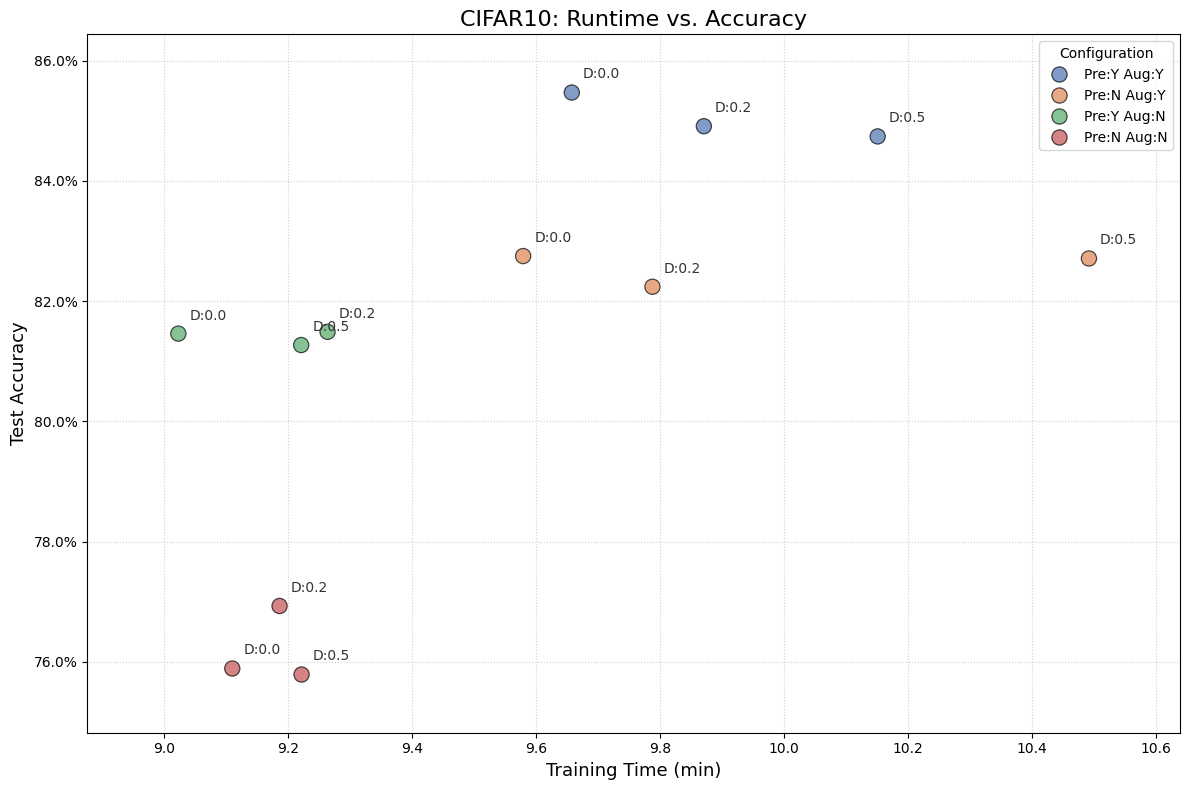

Saved: analyse_plot/scatter_runtime_accuracy_unfrozen_cifar10.png


In [31]:
def plot_filtered_scatter(df_table):
    if df_table is None or df_table.empty:
        print("⚠️ No data available.")
        return
    
    plot_df = df_table.copy()
    
    x_col = "Total Time" if "Total Time" in plot_df.columns else "Runtime (min)"
    y_col = "Max Acc" if "Max Acc" in plot_df.columns else "max_acc"
    
    if "Frz." in plot_df.columns:
        plot_df = plot_df[plot_df["Frz."].isin(["No", 0, False, "N"])]
    
    if plot_df.empty:
        print("⚠️ No data remaining (maybe only Freeze=Yes runs exist?).")
        return
    
    # 1. Helper für die 4 farblichen Gruppen (Pre + Aug Kombination)
    def get_group_name(row):
        p = "Y" if row["Pretr."] in ["Yes", 1, True, "Y"] else "N"
        a = "Y" if row["Aug"] in ["Yes", 1, True, "Y"] else "N"
        return f"Pre:{p} Aug:{a}"

    # 2. Helper für das verkürzte Label am Punkt (nur Dropout)
    def get_short_label(row):
        val = row.get("Drop", "?")
        return f"D:{val}"
    
    # Neue Spalten anwenden
    plot_df["Group"] = plot_df.apply(get_group_name, axis=1)
    plot_df["Label"] = plot_df.apply(get_short_label, axis=1)

    plt.figure(figsize=(12, 8))
    
    # Scatterplot mit Seaborn für Farben
    sns.scatterplot(
        data=plot_df,
        x=x_col, 
        y=y_col, 
        hue="Group",        
        marker='o',         
        s=120,
        alpha=0.7,
        edgecolor='black',
        palette="deep"      
    )
    
    for _, row in plot_df.iterrows():
        # --- KORREKTUR: plt.annotate statt plt.text ---
        plt.annotate(
            text=row["Label"],          # Der Text (D:...)
            xy=(row[x_col], row[y_col]),# Der Punkt, auf den sich der Text bezieht
            xytext=(8, 8),              # Verschiebung in Punkten (x, y)
            textcoords='offset points', # Koordinatensystem für die Verschiebung
            fontsize=10,
            color='#333333',
            weight='normal',
            ha='left',
            va='bottom'
        )
        # --- KORREKTUR ENDE ---
    
    plt.title(f"{SELECTED_DATASET.upper()}: Runtime vs. Accuracy", fontsize=16)
    plt.xlabel("Training Time (min)", fontsize=13)
    plt.ylabel("Test Accuracy", fontsize=13)
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    plt.legend(title="Configuration", loc='best')

    plt.margins(x=0.1, y=0.1)
    plt.tight_layout()
    
    filename = OUTPUT_DIR / f"scatter_runtime_accuracy_unfrozen_{SELECTED_DATASET}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")

plot_filtered_scatter(result_table)

In [32]:
# ==========================================
# ADVANCED SUMMARY TABLE (ZEITEN NACH MAX EPOCH)
# ==========================================

THRESHOLD_TOLERANCE = 0.01

def get_convergence_info(history):
    keys = ['eval_acc', 'val_acc', 'val_accuracy', 'balanced_accuracy', 'overall_accuracy', 'accuracy']
    val_acc_key = next((k for k in keys if k in history), None)
    
    train_times = history.get("train_time_s", [])
    eval_times = history.get("eval_time_s", [])
    
    if val_acc_key and history[val_acc_key]:
        values = history[val_acc_key]
        max_idx = np.argmax(values) # Index der besten Epoche
        max_val = values[max_idx]
        
        # --- Efficiency Calculation ---
        target_val = max_val * (1 - THRESHOLD_TOLERANCE)
        candidates = np.where(np.array(values[:max_idx+1]) >= target_val)[0]
        
        if len(candidates) > 0:
            eff_idx = candidates[0]
            eff_acc = values[eff_idx]
        else:
            eff_idx = max_idx 
            eff_acc = max_val
        
        # --- ZEITEN BERECHNEN (NACH MAX EPOCH) ---
        
        # 1. Train Time: Summe bis zur Max Epoch (Wie lange bis zum besten Ergebnis?)
        if train_times and len(train_times) > max_idx:
            time_to_peak = sum(train_times[:max_idx+1]) / 60.0 # Minuten
            time_to_eff  = sum(train_times[:eff_idx+1]) / 60.0
        else:
            time_to_peak = 0.0
            time_to_eff = 0.0
            
        # 2. Test Time: Dauer der Inferenz in der Max Epoche
        if eval_times and len(eval_times) > max_idx:
            test_time_at_peak = eval_times[max_idx] # Sekunden
        else:
            # Fallback auf Durchschnitt, falls Epoche fehlt (sollte nicht passieren)
            test_time_at_peak = np.mean(eval_times) if eval_times else 0.0
        
        return {
            "max_epoch": max_idx + 1,
            "max_acc": max_val,
            "time_to_peak": time_to_peak,      # <--- Unsere neue Train Time
            "test_time_at_peak": test_time_at_peak, # <--- Unsere neue Test Time
            "eff_epoch": eff_idx + 1,
            "eff_acc": eff_acc,
            "time_to_eff": time_to_eff
        }
    
    return {
        "max_epoch": None, "max_acc": 0, "time_to_peak": 0, "test_time_at_peak": 0,
        "eff_epoch": None, "eff_acc": 0, "time_to_eff": 0
    }

def create_advanced_summary(df, dataset_name="gtsrb"):
    if df.empty: 
        return
    
    subset = df.copy()
    
    # --- Feature Engineering ---
    if "Pretrained" in subset.columns and "pretrained" not in subset.columns:
        subset["pretrained"] = subset["Pretrained"].apply(lambda x: 1 if x == "Yes" else 0)
    
    if "Freeze" in subset.columns and "freeze_backbone" not in subset.columns:
        subset["freeze_backbone"] = subset["Freeze"].apply(lambda x: 1 if x == "Yes" else 0)
    
    for c in ["augment", "dropout", "pretrained", "freeze_backbone"]:
        if c not in subset.columns: 
            subset[c] = 0
            
    # Metrics extrahieren
    metrics_df = subset["history"].apply(lambda h: pd.Series(get_convergence_info(h)))
    subset = pd.concat([subset, metrics_df], axis=1)
    
    # Sortieren & Deduplizieren
    subset = subset.sort_values(by=["epochs", "max_acc"], ascending=[False, False])
    group_cols = ["augment", "dropout", "pretrained", "freeze_backbone"]
    best_runs = subset.drop_duplicates(subset=group_cols)
    
    # Spaltenauswahl
    cols = [
        "augment", "dropout", "pretrained", "freeze_backbone",
        "epochs", 
        "time_to_peak",      # Train Time bis Peak
        "test_time_at_peak", # Test Time beim Peak
        "max_acc", "max_epoch",
        "eff_epoch", "time_to_eff",
        "F1-Score"
    ]
    
    cols = [c for c in cols if c in best_runs.columns]
    
    # Sortierung
    sort_crit = "F1-Score" if "F1-Score" in best_runs.columns else "max_acc"
    final_table = best_runs[cols].sort_values(by=[sort_crit], ascending=False)
    
    # Umbenennung
    eff_ep_name = f"Eff. Ep ({int((1-THRESHOLD_TOLERANCE)*100)}%)"
    rename_map = {
        "augment": "Aug", 
        "dropout": "Drop", 
        "pretrained": "Pretr.", 
        "freeze_backbone": "Frz.",
        "epochs": "Total Ep", 
        "time_to_peak": "Train Time (to Peak)", # <--- KLARE BENENNUNG
        "test_time_at_peak": "Test Time (at Peak)", # <--- KLARE BENENNUNG
        "max_acc": "Max Acc", 
        "max_epoch": "Peak Ep", 
        "eff_epoch": eff_ep_name, 
        "time_to_eff": "Time @ Eff",
        "F1-Score": "Weighted F1"
    }
    final_table = final_table.rename(columns=rename_map)
    
    # Boolean/Binary zu Text
    for col in ["Aug", "Pretr.", "Frz."]:
        if col in final_table.columns:
            final_table[col] = final_table[col].apply(
                lambda x: "Yes" if x in [1, 1.0, True, "Yes", "True"] else "No"
            )
    
    # CSV Speichern
    csv_filename = f"final_analysis_{dataset_name}.csv"
    final_table.to_csv(OUTPUT_DIR / csv_filename, index=False)
    print(f"✓ Table saved: {OUTPUT_DIR / csv_filename}")
    
    print(f"\n--- {dataset_name.upper()}: FINAL ANALYSIS (Times based on Max Epoch) ---")
    
    # --- Styling ---
    styler = final_table.style.background_gradient(subset=["Max Acc"], cmap="Greens")
    
    if "Weighted F1" in final_table.columns:
        styler = styler.background_gradient(subset=["Weighted F1"], cmap="Greens")
    
    # Zeit-Spalten rot färben
    time_cols = [c for c in ["Train Time (to Peak)", "Time @ Eff", "Test Time (at Peak)"] if c in final_table.columns]
    if time_cols: 
        styler = styler.background_gradient(subset=time_cols, cmap="Reds")
    
    if eff_ep_name in final_table.columns:
        styler = styler.background_gradient(subset=[eff_ep_name], cmap="YlOrRd_r")
    
    # Formatierung
    display(styler.format({
        "Max Acc": "{:.2%}", 
        "Weighted F1": "{:.2%}",
        "Total Ep": "{:.0f}", 
        "Peak Ep": "{:.0f}", 
        eff_ep_name: "{:.0f}",
        "Train Time (to Peak)": "{:.1f} min", # <--- Minuten
        "Time @ Eff": "{:.1f} min",
        "Test Time (at Peak)": "{:.2f} s",    # <--- Sekunden
        "Drop": "{:.1f}"
    }, na_rep="-"))
    
    return final_table

# Aufruf
result_table = create_advanced_summary(df, dataset_name=SELECTED_DATASET)

✓ Table saved: analyse_plot/final_analysis_cifar10.csv

--- CIFAR10: FINAL ANALYSIS (Times based on Max Epoch) ---


,Aug,Drop,Pretr.,Frz.,Total Ep,Train Time (to Peak),Test Time (at Peak),Max Acc,Peak Ep,Eff. Ep (99%),Time @ Eff
17,Yes,0.0,Yes,No,30,9.7 min,1.20 s,85.47%,30,22,7.1 min
0,Yes,0.2,Yes,No,30,8.6 min,1.07 s,84.91%,26,21,7.0 min
16,Yes,0.5,Yes,No,30,7.5 min,1.35 s,84.74%,22,20,6.7 min
6,Yes,0.0,No,No,30,8.3 min,1.13 s,82.75%,26,26,8.3 min
5,Yes,0.5,No,No,30,9.1 min,1.18 s,82.71%,26,26,9.1 min
14,Yes,0.2,No,No,30,8.5 min,1.32 s,82.24%,26,24,7.8 min
10,No,0.2,Yes,No,30,4.4 min,1.21 s,81.49%,14,6,1.9 min
2,No,0.0,Yes,No,30,1.8 min,1.14 s,81.46%,6,6,1.8 min
4,No,0.5,Yes,No,30,5.2 min,1.35 s,81.27%,17,6,1.9 min
12,No,0.2,No,No,30,5.5 min,1.13 s,76.93%,18,17,5.2 min
